# EXERCISE 5.5: Object detection using Google Earth Engine  

---

**Use of Google Earth Engine to:**
* a) Clip an AOI from an image collection and filter by time  
* b) Apply canny edge detection 
* c) Ppply Hough transform 
* d) Compare to ground truth 

**Detecting Field Boundaries for Vaalharts Irrigation**
Field delineation is important in developing and managing agricultural-related policies. Given an input satellite image, the goal is to output the delineated boundaries between farm parcels, or the segmentation masks of farm parcels.



### Install geemap
We will use the `geemap` library to display maps and convert GEE Images to Numpy arrays.

In [ ]:
!pip install geemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.4 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11135 sha256=b4c8b4d9833edeed46b7d8034a6d1fe0181bead8dba0a2a957ac7e

### Run me first

Run the following cell to initialize the Earth Engine API. The output will contain instructions on how to grant this notebook access to Earth Engine using your account.


1.   Run the cell below and you will be prompted to enter a verification code.
2.   Follow the link below.
3.   Make sure the google account is the account you created your ML4EO project with
4. Make sure the project ML4EO is selected (you already set this up in 5_02)
5. Click "Generate Token"
6. Click on the Google account you are running this notebook from.
7. Click continue
8. In the page that appears, ensure "View and manage your Google Earth Engine data." and "Manage your data and permissions in Cloud Storage and see the email address for your Google Account." are both checked.
9. Copy the code you see under "Authorization Code" and paste it in the prompt below the cell.


In [ ]:
import ee
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=oen5i1yBz8sycXSiUX624AeQzcBiyCYrL7U4dDJ587k&tc=qWXLLkqLnXlFuK6SJEu7mv6_oyPEjsFffbXy3XtiqZQ&cc=jDB0gVdvP1oNfaaPGRTalbXgbNneFYVz5skFjkohGYs

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AVHEtk4ZzG-Wc4CGL7IaRylh62VHm65aDReWxtud6x9zqxNwS6VIrBbNeyA

Successfully saved authorization token.


In [ ]:
import geemap
import folium
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Edge Detection for Field Boundary Detection
Edge detection is an image processing technique for finding the boundaries of objects within images. It works by detecting discontinuities in brightness. Edge detection is used for image segmentation and data extraction in areas such as image processing, computer vision, and machine vision.

Common edge detection algorithms include Sobel, Canny, Prewitt, Roberts, and fuzzy logic methods.

In this excercise, we will use Canny edge detection to determine the boundaries of fields in VaalHarts Irrigation.
First we specify a polygon geometry for our ROI:

In [ ]:
roi = [
          [24.65986591490829, -28.09412322046305],
          [24.70106464537704, -28.054136830234732],
          [24.754622994986416, -28.032319800398245],
          [24.78071552428329, -28.03110761344614],
          [24.790328561392666, -28.004436046690174],
          [24.82466083678329, -27.9862471006372],
          [24.87135273131454, -27.941367915030856],
          [24.883712350455166, -27.90982002972256],
          [24.86860614928329, -27.866123149358096],
          [24.850753366080166, -27.811477263231893],
          [24.83564716490829, -27.7798915448951],
          [24.817794381705166, -27.750727353214696],
          [24.806808053580166, -27.710613834239876],
          [24.798568307486416, -27.674134193214723],
          [24.79719501647079, -27.637642367457204],
          [24.78346210631454, -27.62547571967499],
          [24.790328561392666, -27.59018479545873],
          [24.80268818053329, -27.58288180594306],
          [24.81092792662704, -27.567056993780913],
          [24.75599628600204, -27.508607155782826],
          [24.738143502798916, -27.514697130897716],
          [24.72578388365829, -27.532965033096218],
          [24.705184518423916, -27.562187361647396],
          [24.69282489928329, -27.59627024850316],
          [24.70106464537704, -27.615741427797115],
          [24.73402362975204, -27.61209084526035],
          [24.743636666861416, -27.62547571967499],
          [24.70106464537704, -27.64007553470646],
          [24.67909198912704, -27.659538924478802],
          [24.66810566100204, -27.6887275123932],
          [24.680465280142666, -27.71304537681072],
          [24.70106464537704, -27.721555348922188],
          [24.705184518423916, -27.745865894894138],
          [24.696944772330166, -27.78839629503583],
          [24.69557148131454, -27.802974318988497],
          [24.71754413756454, -27.813906553629074],
          [24.779342233267666, -27.886759984989332],
          [24.79275012793895, -27.90218116928733],
          [24.810602911142077, -27.922204424412513],
          [24.81678272071239, -27.935551201379933],
          [24.79206348243114, -27.945256912915184],
          [24.735758550790514, -27.964665719488632],
          [24.702799566415514, -27.982858306056414],
          [24.669840582040514, -27.999835284900435],
          [24.650614507821764, -28.014384852612626],
          [24.647867925790514, -28.031356864152194],
          [24.642374761728014, -28.039841866403265],
          [24.61628223243114, -28.045902172596353],
          [24.5977428037202, -28.050750171693185],
          [24.579203375009264, -28.04165999411288],
          [24.56684375586864, -28.04105395495732],
          [24.568217046884264, -28.057415813567268],
          [24.57851672950145, -28.067716447153607],
          [24.629328497079577, -28.098006704812327]]

vaalharts_irrigation_scheme = ee.Geometry.Polygon([roi])

Now let's clip Sentinel 2 images for our ROI and filter by specific time intervals:

In [ ]:
sentinel2_level1c = ee.ImageCollection("COPERNICUS/S2");

# Get monthly clear Sentinel-2 Level-1C images for November 2016 - April 2017  
nov_2016 = ee.Image('COPERNICUS/S2/20161126T080252_20161126T082438_T35JKK').clip(vaalharts_irrigation_scheme)
 
dec_2016 = ee.Image('COPERNICUS/S2/20161229T081332_20161229T083640_T35JKK').clip(vaalharts_irrigation_scheme)
 
jan_2017 = ee.Image('COPERNICUS/S2/20170128T081201_20170128T083151_T35JKK').clip(vaalharts_irrigation_scheme)

feb_2017 = ee.Image('COPERNICUS/S2/20170217T081001_20170217T083329_T35JKK').clip(vaalharts_irrigation_scheme)

mar_2017 = ee.Image('COPERNICUS/S2/20170326T080001_20170326T082243_T35JKK').clip(vaalharts_irrigation_scheme)

apr_2017 = ee.Image('COPERNICUS/S2/20170428T081011_20170428T083712_T35JKK').clip(vaalharts_irrigation_scheme)

#### Draw the Area of Interest on a Map

In [ ]:
center = [-27.768264, 24.769355]
map = geemap.Map(center=center, zoom=11)
map.setOptions('SATELLITE')
map

# Canny Edge Detection
Canny Edge Detection is a popular edge detection algorithm developed by John F. Canny in 1986. We use edge detection in Earth observation to identify significant transitions in pixel values, which represent changes in features such as land cover, vegetation, water bodies, or urban structures. We can then use the resulting data for a variety of analyses. 

Moreover, edge detection can be used to create machine learning training data, particularly for tasks involving object recognition, segmentation, and classification in images. By extracting edges from images, you can obtain valuable information about the boundaries, shapes, and structures of objects, which can serve as features for machine learning models. 



GEE contains an implementation of Canny edge detection algorithm.
Here is the description of GEE's Canny implementation.


`ee.Algorithms.CannyEdgeDetector`
Applies the Canny edge detection algorithm to an image. The output is an image whose bands have the same names as the input bands, and in which non-zero values indicate edges, and the magnitude of the value is the gradient magnitude.

<table class="details"><thead><tr><th>Argument</th><th>Type</th><th>Details</th></tr></thead><tbody><tr><td><code translate="no" dir="ltr">image</code></td><td>Image</td><td>The image on which to apply edge detection.</td></tr><tr><td><code translate="no" dir="ltr">threshold</code></td><td>Float</td><td>Threshold value. The pixel is only considered for edge detection if the gradient magnitude is higher than this threshold.</td></tr><tr class="docs-arg-optional"><td><code translate="no" dir="ltr">sigma</code></td><td>Float, default: 1</td><td>Sigma value for a gaussian filter applied before edge detection. 0 means apply no filtering.</td></tr></tbody></table>

In [ ]:
def aggregate_canny_edges(image, threshold, sigma):
  # Get Canny edge for Red, Green, Blue, and NIR
  canny_red = ee.Algorithms.CannyEdgeDetector(**{
    "image": image.select('B4'), "threshold": threshold, "sigma": sigma
  })
  
  canny_green = ee.Algorithms.CannyEdgeDetector(**{
    "image": image.select('B3'), "threshold": threshold, "sigma": sigma
  })
  
  canny_blue = ee.Algorithms.CannyEdgeDetector(**{
    "image": image.select('B2'), "threshold": threshold, "sigma": sigma
  })
  
  canny_nir = ee.Algorithms.CannyEdgeDetector(**{
    "image": image.select('B8'), "threshold": threshold, "sigma": sigma
  })
  
  # Aggregate R/G/B/NIR Canny edges
  canny_aggregate = canny_red.add(canny_green).add(canny_blue).add(canny_nir).select(['B4'], ['canny_rgbn']);
    
  return canny_aggregate

In [ ]:
threshold = 500
sigma = 1.5
zoom_level = 11

canny_agg_nov_2016 = aggregate_canny_edges(nov_2016, threshold, sigma)
canny_agg_dec_2016 = aggregate_canny_edges(dec_2016, threshold, sigma)
canny_agg_jan_2017 = aggregate_canny_edges(jan_2017, threshold, sigma)
canny_agg_feb_2017 = aggregate_canny_edges(feb_2017, threshold, sigma)
canny_agg_mar_2017 = aggregate_canny_edges(mar_2017, threshold, sigma)
canny_agg_apr_2017 = aggregate_canny_edges(apr_2017, threshold, sigma)

In [ ]:
# Combine the detected edges from all the months
canny_agg_all = (canny_agg_nov_2016
  .add(canny_agg_dec_2016)
  .add(canny_agg_jan_2017)
  .add(canny_agg_feb_2017)
  .add(canny_agg_mar_2017)
  .add(canny_agg_apr_2017)
)

We will now use GEE's updateMask function to make the non-edge pixels transparent. To accomplish this, the `updateMask` function will be used.

`ee.Image.updateMask`
Updates an image's mask at all positions where the existing mask is not zero. The output image retains the metadata and footprint of the input image.
<table class="details"><thead><tr><th>Argument</th><th>Type</th><th>Details</th></tr></thead><tbody><tr><td>this: <code translate="no" dir="ltr">image</code></td><td>Image</td><td>Input image.</td></tr><tr><td><code translate="no" dir="ltr">mask</code></td><td>Image</td><td>New mask for the image, as a floating-point value in the range [0, 1] (invalid = 0, valid = 1). If this image has a single band, it is used for all bands in the input image; otherwise, must have the same number of bands as the input image.</td></tr></tbody></table>

In [ ]:
# Create an image that is white at the edges but transparent elsewhere
edges = canny_agg_all.updateMask(canny_agg_all.gt(0))

In [ ]:
Map = geemap.Map(center=center, zoom=zoom_level)
Map.setOptions('SATELLITE')
Map


Map(center=[-27.768264, 24.769355], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [ ]:
# Draw the detected edges to map
Map.addLayer(canny_agg_nov_2016, {}, 'Canny 4-Band Aggregate - Nov 2016')
Map.addLayer(canny_agg_dec_2016, {}, 'Canny 4-Band Aggregate - Dec 2016')
Map.addLayer(canny_agg_jan_2017, {}, 'Canny 4-Band Aggregate - Jan 2017')
Map.addLayer(canny_agg_feb_2017, {}, 'Canny 4-Band Aggregate - Feb 2017')
Map.addLayer(canny_agg_mar_2017, {}, 'Canny 4-Band Aggregate - Mar 2017')
Map.addLayer(canny_agg_apr_2017, {}, 'Canny 4-Band Aggregate - Apr 2017')
Map.addLayer(canny_agg_all, {}, 'Canny 4-Band Aggregate - All Months')
Map.addLayer(edges, {"palette": ['white']}, 'Canny Edges - No Background');


## <font color=orange>Discussion:</font>
First go to the right top corner of the map and uncheck all the layers except "Google Satellite" and "Canny Edges- No background". Then, zoom in into the given image. Is the detected boundary is good enough (in your judgement)?

## Question 5.5.1
1. Change the threshold to 1500 above and keep the sigma at 1.5 and the zoom level to 14. Rerun the cells above. Uncheck all the layers except "Google Satellite" and "Canny Edges- No background" and take a screenshot of the output image.
2. Change the threshold to 500 above and keep the sigma at 2.5 and the zoom level to 14. Rerun the cells above. Uncheck all the layers except "Google Satellite" and "Canny Edges- No background" and take a screenshot of the output image.
3. Change the threshold to 1500 above and keep the sigma at 2.5 and the zoom level to 14. Rerun the cells above. Uncheck all the layers except "Google Satellite" and "Canny Edges- No background" and take a screenshot of the output image.

Save each image as `field-<threshold>-<sigma>.png` for submission.

## <font color=orange>Discussion:</font>
From the results above, how does changing the threshold affect the detected boundary? How does changing the sigma affect the detected threshold?

## Question 5.5.2: Application Exercise
Notice that we used the RGB and NIR bands to detect edges. Knowing that this is an agricutural field we surmise that using NDVI might give the best results. For this excercise, do the following:
1. Compute NDVI for the `nov_2016` image and save it as a band called `ndvi`
2. Use Canny edge detection to detect edges in the `ndvi` band
3. Display the detected result on a map

In [ ]:
def addNDVI(image):
  ndvi = image.normalizedDifference(['B8', 'B4']).rename('ndvi')
  return image.addBands(ndvi)

threshold = 0.1
sigma = 1.5
withNDVI = addNDVI(nov_2016)
canny_ndvi = ee.Algorithms.CannyEdgeDetector(**{
    "image": withNDVI.select('ndvi'), "threshold": threshold, "sigma": sigma
  })
edges = canny_agg_all.updateMask(canny_ndvi.gt(0))


In [ ]:
center = [-27.768264, 24.769355]
Map2 = geemap.Map(center=center, zoom=14)
Map2.setOptions('SATELLITE')

Map2


Map(center=[-27.768264, 24.769355], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [ ]:
Map2.addLayer(edges, {"palette": ['white']}, 'Canny Edges NDVI - No Background')


## Export GEE Images to Numpy
Sometimes the tools that GEE provides for image manipulation may not be sufficient for complex operations. If we would like to use more sophisticated image processing/computer vision algorithms, we may export GEE images to Numpy and process the images with OpenCV.

OpenCV (Open Source Computer Vision Library) is a library of programming functions mainly for real-time computer vision. 

For this example, we will use OpenCV's Canny edge detection implementation to detect the edges of the fields in the image.

To export images to Numpy, we use `geemap`'s `ee_to_numpy` function.

**geemap.ee_to_numpy**(*ee_object, bands, region, properties, default_value*)
```
Extracts a rectangular region of pixels from an image into a 2D numpy array per band.

    Args:
        ee_object (object): The image to sample.
        bands (list, optional): The list of band names to extract. Please make sure that all bands have the same spatial resolution. Defaults to None.
        region (object, optional): The region whose projected bounding box is used to sample the image. The maximum number of pixels you can export is 262,144. Resampling and reprojecting all bands to a fixed scale can be useful. Defaults to the footprint in each band.
        properties (list, optional): The properties to copy over from the sampled image. Defaults to all non-system properties.
        default_value (float, optional): A default value used when a sampled pixel is masked or outside a band's footprint. Defaults to None.

    Returns:
        array: A 3D numpy array.
```



The images in our dataset are high-resolution images and exporting any image covering a large region becomes prohibitively large. Thus, we will export a portion of the Vaalharts irrigation for processing by OpenCV.

In [ ]:
# Define a small area of interest within the Vaalharts irrigation

aoi_corners = [[24.75, -27.75], [24.75, -27.77], [24.77, -27.77], [24.77, -27.75]]
aoi = ee.Geometry.Polygon(
    [aoi_corners], None, False
)

# convert the RGB bands of EE.Image to numpy array
out = geemap.ee_to_numpy(nov_2016, region=aoi, bands=['B4', 'B3', 'B2']).astype(np.float32)
out /= 10000.0

# min-max normalize the image to range [0, 255]
for i in range(3):
  ch = out[:, :, i]
  # out[:, :, i] = ch/0.3
# Use an 8-bit unsigned integer to represent the pixels in the image
out = (out * 255).astype(np.uint8)

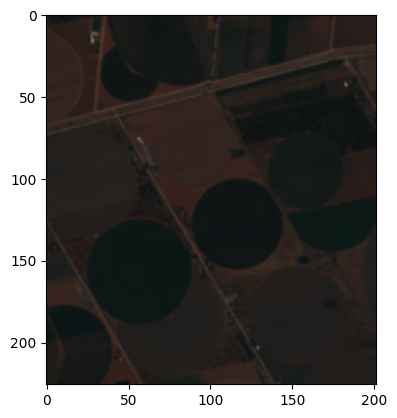

In [ ]:
plt.imshow(out)

### Convert to Grayscale
Canny edge detection expects a single channel image. When applying Canny from GEE we applied Canny to each band individually and aggregated the detections. For this example, we will convert the RGB image to grayscale first and apply edge detection to the gray scale image.

The function `cv2.cvtColor` is used to achieve this.

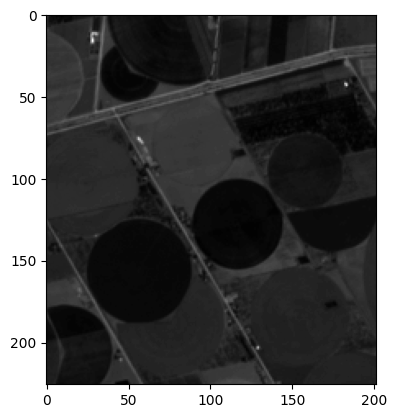

In [ ]:
grayscale = cv2.cvtColor(out, cv2.COLOR_RGB2GRAY)
plt.imshow(grayscale, cmap='gray')

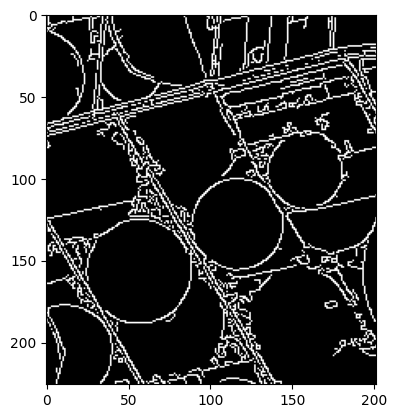

In [ ]:
edges = cv2.Canny(grayscale, 10, 30)
plt.imshow(edges, cmap='gray')

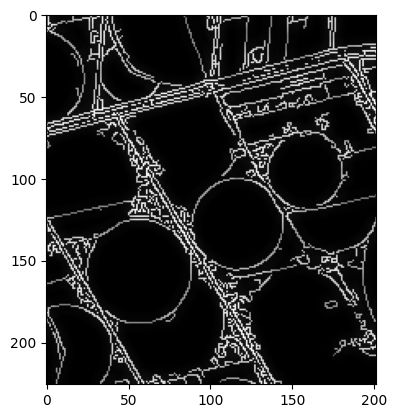

In [ ]:
filtered_edges = cv2.bilateralFilter(edges,15,127,150)
plt.imshow(filtered_edges, cmap='gray')

## <font color=orange>Discussion:</font>
If we want to get a clean circular field boundary detection, what do you think needs to be done?

## Hough Transform
The Hough transform is a feature extraction technique used in image analysis, computer vision, and digital image processing. The purpose of the technique is to find imperfect instances of objects within a certain class of shapes by a voting procedure. 

In our case, we will use the Hough transform to find imperfect circles from our edge image.

OpenCV contains the function `cv2.HoughCircles` that can be used to detect imperfect circles. Its description is given below.

<table class="python_language"><tbody><tr><td style="width: 20px;"></td><td>cv.HoughCircles(</td><td class="paramname">image, method, dp, minDist[, circles[, param1[, param2[, minRadius[, maxRadius]]]]]</td><td>) -&gt; </td><td>circles</td></tr></tbody></table>
<dl class="params"><dt>Parameters</dt><dd>
  <table class="params">
    <tbody><tr><td class="paramname">image</td><td>8-bit, single-channel, grayscale input image. </td></tr>
    <tr><td class="paramname">circles</td><td>Output vector of found circles. Each vector is encoded as 3 or 4 element floating-point vector <span class="MathJax_Preview" style="display: none;"></span><span class="MathJax" id="MathJax-Element-49-Frame" tabindex="0" style=""><nobr><span class="math" id="MathJax-Span-633" style="width: 6.97em; display: inline-block;"><span style="display: inline-block; position: relative; width: 5.682em; height: 0px; font-size: 122%;"><span style="position: absolute; clip: rect(1.232em, 1005.57em, 2.579em, -999.997em); top: -2.163em; left: 0em;"><span class="mrow" id="MathJax-Span-634"><span class="mo" id="MathJax-Span-635" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-636" style="font-family: MathJax_Math-italic;">x</span><span class="mo" id="MathJax-Span-637" style="font-family: MathJax_Main;">,</span><span class="mi" id="MathJax-Span-638" style="font-family: MathJax_Math-italic; padding-left: 0.179em;">y<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-639" style="font-family: MathJax_Main;">,</span><span class="mi" id="MathJax-Span-640" style="font-family: MathJax_Math-italic; padding-left: 0.179em;">r</span><span class="mi" id="MathJax-Span-641" style="font-family: MathJax_Math-italic;">a</span><span class="mi" id="MathJax-Span-642" style="font-family: MathJax_Math-italic;">d<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-643" style="font-family: MathJax_Math-italic;">i</span><span class="mi" id="MathJax-Span-644" style="font-family: MathJax_Math-italic;">u</span><span class="mi" id="MathJax-Span-645" style="font-family: MathJax_Math-italic;">s</span><span class="mo" id="MathJax-Span-646" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.169em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em;"></span></span></nobr></span><script type="math/tex" id="MathJax-Element-49">(x, y, radius)</script> or <span class="MathJax_Preview" style="display: none;"></span><span class="MathJax" id="MathJax-Element-50-Frame" tabindex="0" style=""><nobr><span class="math" id="MathJax-Span-647" style="width: 10.249em; display: inline-block;"><span style="display: inline-block; position: relative; width: 8.375em; height: 0px; font-size: 122%;"><span style="position: absolute; clip: rect(1.232em, 1008.26em, 2.579em, -999.997em); top: -2.163em; left: 0em;"><span class="mrow" id="MathJax-Span-648"><span class="mo" id="MathJax-Span-649" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-650" style="font-family: MathJax_Math-italic;">x</span><span class="mo" id="MathJax-Span-651" style="font-family: MathJax_Main;">,</span><span class="mi" id="MathJax-Span-652" style="font-family: MathJax_Math-italic; padding-left: 0.179em;">y<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-653" style="font-family: MathJax_Main;">,</span><span class="mi" id="MathJax-Span-654" style="font-family: MathJax_Math-italic; padding-left: 0.179em;">r</span><span class="mi" id="MathJax-Span-655" style="font-family: MathJax_Math-italic;">a</span><span class="mi" id="MathJax-Span-656" style="font-family: MathJax_Math-italic;">d<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-657" style="font-family: MathJax_Math-italic;">i</span><span class="mi" id="MathJax-Span-658" style="font-family: MathJax_Math-italic;">u</span><span class="mi" id="MathJax-Span-659" style="font-family: MathJax_Math-italic;">s</span><span class="mo" id="MathJax-Span-660" style="font-family: MathJax_Main;">,</span><span class="mi" id="MathJax-Span-661" style="font-family: MathJax_Math-italic; padding-left: 0.179em;">v</span><span class="mi" id="MathJax-Span-662" style="font-family: MathJax_Math-italic;">o</span><span class="mi" id="MathJax-Span-663" style="font-family: MathJax_Math-italic;">t</span><span class="mi" id="MathJax-Span-664" style="font-family: MathJax_Math-italic;">e</span><span class="mi" id="MathJax-Span-665" style="font-family: MathJax_Math-italic;">s</span><span class="mo" id="MathJax-Span-666" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.169em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em;"></span></span></nobr></span><script type="math/tex" id="MathJax-Element-50">(x, y, radius, votes)</script> . </td></tr>
    <tr><td class="paramname">method</td><td>Detection method, see <a class="el" href="../../dd/d1a/group__imgproc__feature.html#ga073687a5b96ac7a3ab5802eb5510fe65" title="Variants of a Hough transform. ">HoughModes</a>. The available methods are <a class="el" href="../../dd/d1a/group__imgproc__feature.html#gga073687a5b96ac7a3ab5802eb5510fe65ab1bf00a90864db34b2f72fa76389931d" title="basically 21HT, described in  ">HOUGH_GRADIENT</a> and <a class="el" href="../../dd/d1a/group__imgproc__feature.html#gga073687a5b96ac7a3ab5802eb5510fe65aad57c72131c801de427f1fdb55c8c8ad" title="variation of HOUGH_GRADIENT to get better accuracy ">HOUGH_GRADIENT_ALT</a>. </td></tr>
    <tr><td class="paramname">dp</td><td>Inverse ratio of the accumulator resolution to the image resolution. For example, if dp=1 , the accumulator has the same resolution as the input image. If dp=2 , the accumulator has half as big width and height. For <a class="el" href="../../dd/d1a/group__imgproc__feature.html#gga073687a5b96ac7a3ab5802eb5510fe65aad57c72131c801de427f1fdb55c8c8ad" title="variation of HOUGH_GRADIENT to get better accuracy ">HOUGH_GRADIENT_ALT</a> the recommended value is dp=1.5, unless some small very circles need to be detected. </td></tr>
    <tr><td class="paramname">minDist</td><td>Minimum distance between the centers of the detected circles. If the parameter is too small, multiple neighbor circles may be falsely detected in addition to a true one. If it is too large, some circles may be missed. </td></tr>
    <tr><td class="paramname">param1</td><td>First method-specific parameter. In case of <a class="el" href="../../dd/d1a/group__imgproc__feature.html#gga073687a5b96ac7a3ab5802eb5510fe65ab1bf00a90864db34b2f72fa76389931d" title="basically 21HT, described in  ">HOUGH_GRADIENT</a> and <a class="el" href="../../dd/d1a/group__imgproc__feature.html#gga073687a5b96ac7a3ab5802eb5510fe65aad57c72131c801de427f1fdb55c8c8ad" title="variation of HOUGH_GRADIENT to get better accuracy ">HOUGH_GRADIENT_ALT</a>, it is the higher threshold of the two passed to the Canny edge detector (the lower one is twice smaller). Note that <a class="el" href="../../dd/d1a/group__imgproc__feature.html#gga073687a5b96ac7a3ab5802eb5510fe65aad57c72131c801de427f1fdb55c8c8ad" title="variation of HOUGH_GRADIENT to get better accuracy ">HOUGH_GRADIENT_ALT</a> uses <a class="el" href="../../d4/d86/group__imgproc__filter.html#gaa13106761eedf14798f37aa2d60404c9" title="Calculates the first x- or y- image derivative using Scharr operator. ">Scharr</a> algorithm to compute image derivatives, so the threshold value shough normally be higher, such as 300 or normally exposed and contrasty images. </td></tr>
    <tr><td class="paramname">param2</td><td>Second method-specific parameter. In case of <a class="el" href="../../dd/d1a/group__imgproc__feature.html#gga073687a5b96ac7a3ab5802eb5510fe65ab1bf00a90864db34b2f72fa76389931d" title="basically 21HT, described in  ">HOUGH_GRADIENT</a>, it is the accumulator threshold for the circle centers at the detection stage. The smaller it is, the more false circles may be detected. Circles, corresponding to the larger accumulator values, will be returned first. In the case of <a class="el" href="../../dd/d1a/group__imgproc__feature.html#gga073687a5b96ac7a3ab5802eb5510fe65aad57c72131c801de427f1fdb55c8c8ad" title="variation of HOUGH_GRADIENT to get better accuracy ">HOUGH_GRADIENT_ALT</a> algorithm, this is the circle "perfectness" measure. The closer it to 1, the better shaped circles algorithm selects. In most cases 0.9 should be fine. If you want get better detection of small circles, you may decrease it to 0.85, 0.8 or even less. But then also try to limit the search range [minRadius, maxRadius] to avoid many false circles. </td></tr>
    <tr><td class="paramname">minRadius</td><td>Minimum circle radius. </td></tr>
    <tr><td class="paramname">maxRadius</td><td>Maximum circle radius. If &lt;= 0, uses the maximum image dimension. If &lt; 0, <a class="el" href="../../dd/d1a/group__imgproc__feature.html#gga073687a5b96ac7a3ab5802eb5510fe65ab1bf00a90864db34b2f72fa76389931d" title="basically 21HT, described in  ">HOUGH_GRADIENT</a> returns centers without finding the radius. <a class="el" href="../../dd/d1a/group__imgproc__feature.html#gga073687a5b96ac7a3ab5802eb5510fe65aad57c72131c801de427f1fdb55c8c8ad" title="variation of HOUGH_GRADIENT to get better accuracy ">HOUGH_GRADIENT_ALT</a> always computes circle radiuses.</td></tr>
  </tbody></table>
  </dd>
</dl>

In [ ]:
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 0.1, minDist=min(edges.shape)//3, param2=5, maxRadius=min(edges.shape)//6)


Now that we have found the circles let's draw the circles to an image.

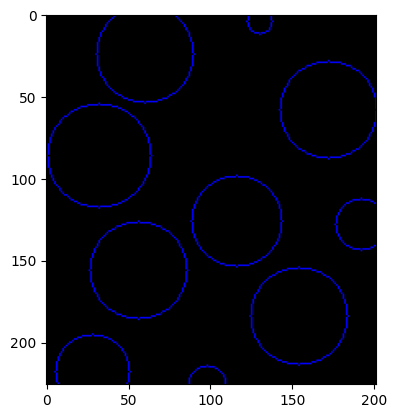

In [ ]:
# Create a new image where detected circles are drawn to
output = np.zeros(edges.shape + (3, ), dtype=np.uint8)

# ensure at least some circles were found
if circles is not None:
	# convert the (x, y) coordinates and radius of the circles to integers
	circles_i = np.round(circles[0, :]).astype("int")
	# loop over the (x, y) coordinates and radius of the circles

	for (x, y, r) in circles_i:
		# draw the circle in the output image
		cv2.circle(output, (x, y), r, (0, 0, 255), 1)
plt.imshow(output)

## <font color=orange>Discussion:</font>
How does changing the param2 argument of Hough Circles change the number of detected circles? Experiment with different `param2` values and determine (in your judgement) what number results in the most accurate detection of circles.

## Transferring results from OpenCV to GEE
Once we have completed our OpenCV image analysis we typically want to transfer the results back to GEE. In our case, we would like to overlay the detected boundaries on a GEE map.

29 0


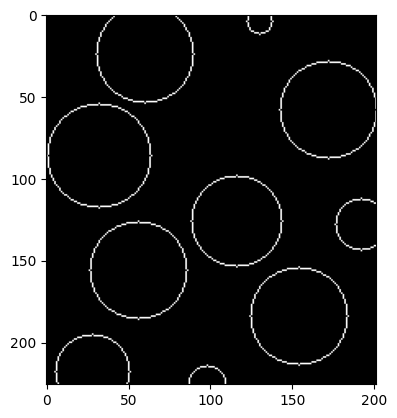

In [ ]:
# convert image to gray scale
output_gray = cv2.cvtColor(output, cv2.COLOR_RGB2GRAY)
print(output_gray.max(), output_gray.min())
_, output_gray = cv2.threshold(output_gray, output_gray.max() // 2, 255, cv2.THRESH_BINARY)

plt.imshow(output_gray, cmap='gray')

In [ ]:
def findTransform(np_img_shape, long_lat_corners):
  Cx, Cy = np_img_shape
  W = np.array([
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1],
    [Cx, 0, 1, 0, 0, 0],
    [0, 0, 0, Cx, 0, 1],
    [Cx, Cy, 1, 0, 0, 0],
    [0, 0, 0, Cx, Cy, 1],
    [0, Cy, 1, 0, 0, 0],
    [0, 0, 0, 0, Cy, 1]
  ])
  pinv = np.linalg.pinv(W)
  transform = pinv @ long_lat_corners
  transform = transform.flatten().tolist()
  return transform

In [ ]:
long_lat_corners = np.array(aoi_corners).reshape((-1, 1))

transform = findTransform(output_gray.shape, long_lat_corners)
gee_image = geemap.numpy_to_ee(output_gray, crs='EPSG:4326', transform=transform, band_names='circles')

gee_image = gee_image.mask(gee_image.select('circles').gt(0))

In [ ]:
center = [-27.768264, 24.769355]
Map2 = geemap.Map(center=center, zoom=14)
Map2.setOptions('SATELLITE')
Map2


Map(center=[-27.768264, 24.769355], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [ ]:
Map2.addLayer(gee_image.select("circles"), {}, 'Detected circles')

Map2.addLayer(aoi, {}, 'Exported Image boundary')


## <font color=orange>Discussion:</font>
What are your observations on the useability of object detection in this example?